In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm


import pandahouse

In [2]:
# устанавливаем connection с БД
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20221120',
                      'user':'USER', 
                      'password':'PASSWORD'
                     }

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-10-26' and '2022-11-01'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df_aa = pandahouse.read_clickhouse(q, connection=connection)

df_aa.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667


# 1 Задание

## А/А тест
Что нужно сделать: у нас есть данные АА-теста с '2022-10-26' по '2022-11-01'. Вам нужно сделать симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации вам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

1. Построить гистограмму распределения получившихся 10000 p-values.

2. Посчитать, какой процент p values оказался меньше либо равен 0.05

3. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

4. Пришлите ссылку на merge request c проведенным анализом.

100%|██████████| 10000/10000 [01:18<00:00, 127.09it/s]


0.0437

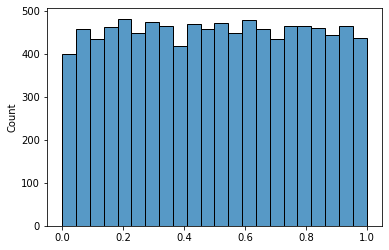

In [3]:
simulations = 10000
n_s = 500
res = []

# A/A тест
for i in tqdm(range(simulations)):
    s1 = df_aa.query('exp_group == 2')['ctr'].sample(n_s, replace = False).values
    s2 = df_aa.query('exp_group == 3')['ctr'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

sns.histplot(res)

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

**Вывод**

система сплитования работает правильно при уровне значимости 0,05

# 2 Задание
Эксперимент проходил с 2022-11-02 по 2022-11-08 включительно. Для эксперимента были задействованы 2 и 1 группы. 
В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

**Ваша задача** — проанализировать данные АB-теста. 

1. Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
2. Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали так как сработали? 
3. Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.
4. Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

In [4]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20221120',
                      'user':'USER', 
                      'password':'PASSWORD'
                     }

q_ab = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-11-02' and '2022-11-08'
    and exp_group in (2,1)
GROUP BY exp_group, user_id
"""

df_ab = pandahouse.read_clickhouse(q_ab, connection=connection)

df_ab.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


# А/B тест

## t-тест на CTR

Нулевая гипотеза H0: μ1 = μ2 

Альтернативная гипотеза H1: μ1 != μ

In [5]:
control = df_ab.query('exp_group == 1')['ctr'].values
test = df_ab.query('exp_group == 2')['ctr'].values
stats.ttest_ind(s1, s2, equal_var = False)

Ttest_indResult(statistic=0.07254532035609622, pvalue=0.9421824759000128)

In [6]:
df_ab.query('exp_group == [1,2]').groupby('exp_group').agg({'ctr':'mean'})

,ctr
exp_group,
1,0.215605
2,0.214419


<AxesSubplot:xlabel='ctr', ylabel='Count'>

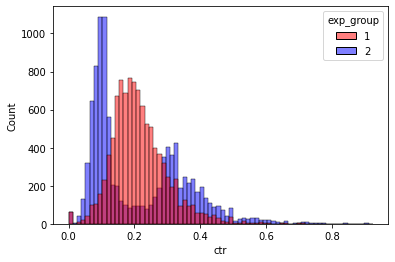

In [7]:
sns.histplot(data=df_ab, 
             x ='ctr', 
             hue='exp_group',
            palette = ['r', 'b'])

**Вывод**

согласно проведенному тесту p value > 0.05, поэтому на данном уровне значимости мы не можем отклонить нулевую гипотезу

## mannwhitneyu-тест на CTR

Нулевая гипотеза H0: P(X > Y) = P(Y > X)  

Альтернативная гипотеза H1: P(X > Y) != P(Y > X)

In [8]:
stats.mannwhitneyu(control, test)

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

**Вывод**

согласно проведенному тесту p value < 0.05, поэтому на данном уровне значимости мы можем отклонить нулевую гипотезу, что видно на графике распределения 2-х выборок, в тестовой выборке распределение изменилось: появились 2 вершины -  превалирующее кол-во пользователей с ctr примерно 0.1, а также увеличилось кол-во пользователеей с ctr 0,3 и более. Кроме того появились лидеры по лайкам с ctr более 0.6

## bootstrap на CTR

H0: значимых различий в тестовой и контрольных выборках нет

H1: есть значимые различия в тестовой и контрольных выборках

In [9]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    
    """
    функция проверяет гипотезы с помощью бутстрапа и возвращает:
            - бутстрапированные данные,
            - левый и правый квантили,
            - значение p-value
    """
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=60,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

100%|██████████| 1000/1000 [00:01<00:00, 605.17it/s]


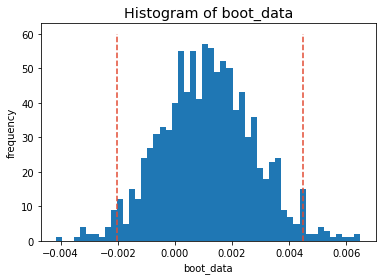

In [10]:
booted_data = get_bootstrap(df_ab.query('exp_group == 1')['ctr'], df_ab.query('exp_group == 2')['ctr']) # в результате хранится разница двух распределений, ДИ и pvalue

In [11]:
booted_data["p_value"]

0.47931132636066864

In [12]:
booted_data["ci"]

,0
0.025,-0.002014
0.975,0.004478


**Вывод**

Согласно проведенному тесту видим, что значение p_value > 0.05 и доверительный интервал имеет границы [-0.001980; 0.004462], в который попадает 0. 
Таким образом, мы не можем отклонить нулевую гипотезу на заданном уровне значимости.

## Пуасоновский бутстреп bootstrap

In [13]:
def poisson_bootstap(likes1, views1, likes2, views2, n_bootstap=1000):

    """
    функция проверяет гипотезы с помощью Пуасоновского бутстрапа и возвращает распредение 2-х CTR
    """
    poisson_bootstaps1 = stats.poisson(1).rvs((1000, len(likes1))).astype(np.int64)
    
    poisson_bootstaps2 = stats.poisson(1).rvs((1000, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstaps1*likes1).sum(axis=1)/(poisson_bootstaps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstaps2*likes2).sum(axis=1)/(poisson_bootstaps2*views2).sum(axis=1)
    
    return globalCTR1, globalCTR2

In [14]:
likes1 = df_ab.query('exp_group == 1')['likes'].to_numpy()
likes2 = df_ab.query('exp_group == 2')['likes'].to_numpy()
views1 = df_ab.query('exp_group == 1')['views'].to_numpy()
views2 = df_ab.query('exp_group == 2')['views'].to_numpy()

In [15]:
ctr1, ctr2 = poisson_bootstap(likes1, views1, likes2, views2, n_bootstap=2000)

<AxesSubplot:ylabel='Count'>

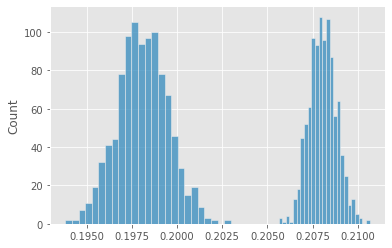

In [16]:
sns.histplot(ctr1) 
sns.histplot(ctr2) 

<AxesSubplot:ylabel='Count'>

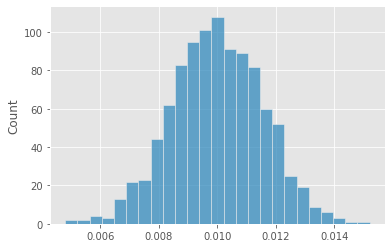

In [17]:
sns.histplot(ctr1 - ctr2) 

**Вывод**

Согласно проведенному тесту видим, что распределение 2 выборок различается между собой, а их разница больше 0, что говорит о том, что мы можем отклонить нулевую гипотезу, о том, что выборки значимо не различаются между собой

## Сглаженный CTR

In [19]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):

    """
    функция считает сглаженный CTR и возвращает его
    """

    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [20]:
global_ctr_1 = df_ab[df_ab.exp_group == 1].likes.sum()/df_ab[df_ab.exp_group == 1].views.sum()
global_ctr_2 = df_ab[df_ab.exp_group == 2].likes.sum()/df_ab[df_ab.exp_group == 2].views.sum()

<AxesSubplot:xlabel='ctr', ylabel='Count'>

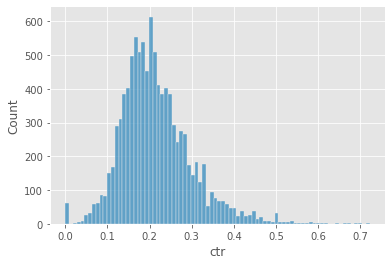

In [21]:
group1 = df_ab[df_ab.exp_group == 1].copy()
sns.histplot(group1.ctr, 
             kde = False)

<AxesSubplot:xlabel='ctr', ylabel='Count'>

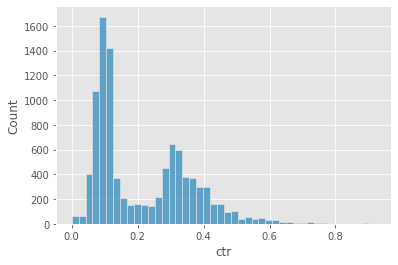

In [22]:
group2 = df_ab[df_ab.exp_group == 2].copy()
sns.histplot(group2.ctr, 
             kde = False)

<AxesSubplot:xlabel='smothed_ctr', ylabel='Count'>

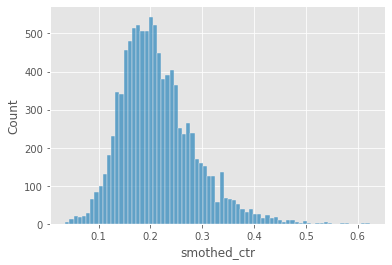

In [23]:
group1['smothed_ctr'] = df_ab.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

sns.histplot(group1.smothed_ctr, 
             kde = False)

<AxesSubplot:xlabel='smothed_ctr', ylabel='Count'>

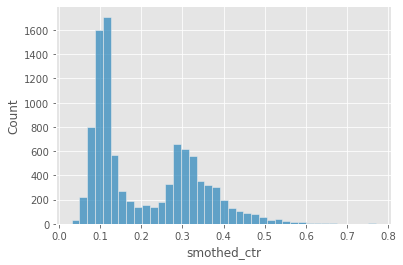

In [24]:
group2['smothed_ctr'] = df_ab.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

sns.histplot(group2.smothed_ctr, 
             kde = False)

In [25]:
group2['smothed_ctr'].mean()

0.21073955503259234

In [26]:
group1['smothed_ctr'].mean()

0.21402549608884142

In [27]:
stats.ttest_ind(group1['smothed_ctr'] , group2['smothed_ctr'] , equal_var = False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

**Вывод**

согласно проведенному тесту p value < 0.05, поэтому на данном уровне значимости мы можем отклонить нулевую гипотезу и принять альтернативную

## Бакетное преобразование

In [28]:
q_bucket = """
SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-11-02' and '2022-11-08'
        and exp_group in (2,1)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_bucket_ctr = pandahouse.read_clickhouse(q_bucket, connection=connection)

stats.mannwhitneyu(df_bucket_ctr[df_bucket_ctr.exp_group == 1].bucket_ctr, 
                   df_bucket_ctr[df_bucket_ctr.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

**Вывод**

согласно проведенному тесту p value < 0.05, поэтому на данном уровне значимости мы можем отклонить нулевую гипотезу и принять альтернативную гипотезу о различии в распределениях в двух выборках

## Выводы
Для анализа данного алгоритма были применены следующие методы t-тест, обычный бутстреп, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) и тест Манна-Уитни поверх бакетного преобразования. Каждый из методов показал себя по-разному.
 1. Т-тест на всей выборке при метрике CTR на пользователя - не нашел значимых различий в средних между 2 выборками. Данный факт связан с тем, что распределения 2 наших выборок различается, и во 2 выборке наблюдаются определенные выбросы (ctr более 0,7), а также перекос в сторону ctr ~ 0.1, что сказывается на среднем значении, которое не сильно отличается от среднего в контрольной выборке.
 2. Обычный бутстреп также не нашел значимых различий в 2 выборках, однако его продвинутая версия Пуассоновский бутстреп нашел различия в 2 выборках
 3. тест Манна-Уитни показал значимые различия, что довольно очевидно так, как мы видим наглядное изменение в распределениях между 2 выборками: если в контрольной оно унимодально и имеет явно выраженное среднее в районе 0.2, то в тестовой выборке мы видим 2 пика: 1 на уровне 0.1 (что наиболее превалирует) и 2 на уровне 0.3. Таким образом видно, что поведение пользователей изменилось. Теперь у довольно большого кол-ва пользователей ctr снизился, однако у 2 половине он повысился, более того можно наблюдать пользователей с ctr более 0.7
 4. t-тест на сглаженном ctr (α=5) также показал значимые различия в выборках, что произошло благодаря сглаживанию ctr в выборках.
 5. тест Манна-Уитни поверх бакетного преобразования также показал значимые различия в выборках.
 
 **Вывод:**
 - Для данного А/B теста я бы выбрал критерий Манна-Уитни, так как он наиболее полно отражается ситуацию при использовании нового алгоритма.
 - Во-первых, мы наблюдаем снижение ctr в тестовой группе (это видно как в обычном ctr, так и в сглаженном), более того при использовании сглаженного ctr снижение среднего значения статически значимо. 
 - Во-вторых, видно, что поведение пользователей изменилось, если раньше у наибольшой части пользователей ctr был в районе 0.2, то в тестовой эта группа образовала 2 группы: 1 на уровне 0.1 и ниже(наибольшая группа) и 2 на уровне 0.3 и выше. То есть алгоритм работает странно, для большинтсва пользователей он начал выдавать странные рекомендации, однако для второй группы он начал выдавать хорошие рекомендации (появились даже те, которые лайкают более 70% постов). Однако наличие большого кол-ва низкого ctr не позволяет говорить о том, что алгоритм сработал
 
 **Вердикт:** данный алгоритм не стоит раскатывать
 
 


# 3 Задание
**Задача**

- Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?
- Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

In [35]:
q_linearized = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-11-02' and '2022-11-08'
    and exp_group in (0, 1, 2, 3)
GROUP BY exp_group, user_id
"""

df_linearized = pandahouse.read_clickhouse(q_linearized, connection=connection)

df_linearized.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,9,30,0.300000
1,1,18392,7,32,0.218750
2,3,123580,13,48,0.270833
3,2,131473,14,134,0.104478
4,2,32420,26,128,0.203125


In [51]:
def get_linearized_likes(user_likes, user_views, global_ctr):

    """
    функция метрику линеаризованных лайков и возвращает их
    """
    
    linearized_likes = (user_likes - global_ctr * user_views)
    return linearized_likes 

In [52]:
group1 = df_ab[df_ab.exp_group == 1].copy()
group2 = df_ab[df_ab.exp_group == 2].copy()
group0 = df_ab[df_ab.exp_group == 0].copy()
group3 = df_ab[df_ab.exp_group == 3].copy()

<AxesSubplot:xlabel='linearized_likes', ylabel='Count'>

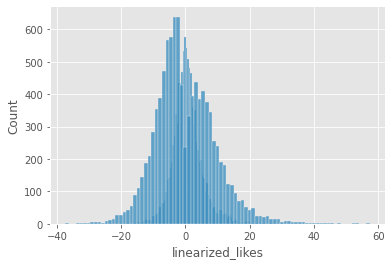

In [53]:
group1['linearized_likes'] = df_linearized.apply(
    lambda x: get_linearized_likes(x['likes'], x['views'], global_ctr_2), axis=1)

sns.histplot(group1['linearized_likes'],
             kde = False)
group2['linearized_likes'] = df_linearized.apply(
    lambda x: get_linearized_likes(x['likes'], x['views'], global_ctr_2), axis=1)

sns.histplot(group2['linearized_likes'],
             kde = False)

In [54]:
stats.ttest_ind(group1['linearized_likes'] , group2['linearized_likes'] , equal_var = False)

Ttest_indResult(statistic=5.875197054309625, pvalue=4.313818677881745e-09)

**Вывод**

согласно проведенному тесту p value < 0.05, поэтому на данном уровне значимости мы можем отклонить нулевую гипотезу и принять альтернативную

<AxesSubplot:xlabel='linearized_likes', ylabel='Count'>

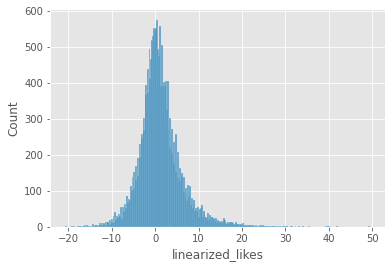

In [56]:
group0['linearized_likes'] = df_linearized.apply(
    lambda x: get_linearized_likes(x['likes'], x['views'], global_ctr_2), axis=1)
sns.histplot(group0['linearized_likes'],
             kde = False)
group3['linearized_likes'] = df_linearized.apply(
    lambda x: get_linearized_likes(x['likes'], x['views'], global_ctr_2), axis=1)
sns.histplot(group3['linearized_likes'],
             kde = False,
            palette = ['r', 'b'])

In [58]:
stats.ttest_ind(group0['linearized_likes'] , group3['linearized_likes'] , equal_var = False)

Ttest_indResult(statistic=-14.514397206083885, pvalue=1.7107859347382044e-47)

**Вывод**

согласно проведенному тесту p value < 0.05, поэтому на данном уровне значимости мы можем отклонить нулевую гипотезу и принять альтернативную

Таким образом, с помощью метрики линеаризованных лайков мы видим значимые различия в обоих тестах, болле того значение p_value очень низкое (близкое к 0)